Enter the LinkedIn profile URL:https://www.linkedin.com/in/ukesh-rajasekar/


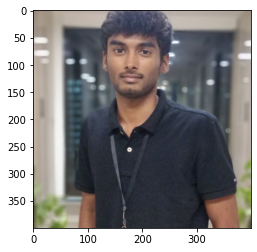

In [5]:
# import web driver
from selenium import webdriver
from parsel import Selector
from time import sleep
import cv2 as cv
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import urllib
import urllib.request as request
from bs4 import BeautifulSoup as BS

def Profile_Pic_Scrapper(url, username, password):
    # specifies the path to the chromedriver.exe
    browser = webdriver.Chrome(r'C:/Users/ukesh/Downloads/chromedriver_win32/chromedriver.exe')

    # driver.get method() will navigate to a page given by the URL address
    browser.get('https://www.linkedin.com/login?fromSignIn=true&trk=guest_homepage-basic_nav-header-signin')

    #fill username and password
    elementId = browser.find_element_by_id('username')
    elementId.send_keys(username)

    elementId = browser.find_element_by_id('password')
    elementId.send_keys(password)

    elementId.submit()



    def get_url(url):
        #url = str(input('Enter the LinkedIn profile URL:'))
        browser.get(url)
        soup = BS(browser.page_source,'html.parser')
        return soup

    soup = get_url(url)
    for img in soup.findAll('img'):
        if img['class'][0] == 'pv-top-card__photo':
            image_url = img.get('src')
        else:
            continue
    browser.quit()
    return image_url
 
def image_reader(image_url):
    file_name = 'profile_picture.png'
    image_file = open(file_name, 'wb')
    image_file.write(request.urlopen(image_url).read())
    image_file.close()

    image = cv.imread(file_name, cv.COLOR_RGB2BGR)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    return image

url = str(input('Enter the LinkedIn profile URL:'))
username = ''
password = ''
image_url = Profile_Pic_Scrapper(url, username, password)
image = image_reader(image_url)
plt.imshow(image)


   *** face feature analysis ***   

Face exposure level: goodExposure

Emotion noticed: neutral


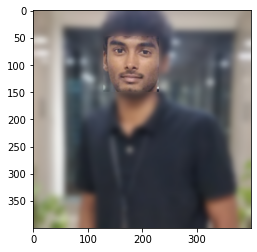

In [6]:
#facial recognition

import sys
import requests
import matplotlib.pyplot as plt



def face_analyser(subscription_key, endpoint):
    face_api_url = endpoint + '/face/v1.0/detect'



    headers = {'Ocp-Apim-Subscription-Key': subscription_key}

    params = {'detectionModel': 'detection_01',
              'returnFaceAttributes': 'age,gender,headPose,smile,facialHair,glasses,emotion,hair,makeup,occlusion,accessories,blur,exposure,noise',
              'returnFaceId': 'true'
    }


    response = requests.post(face_api_url, params=params,
                             headers=headers, json={"url": image_url})

    analysis = response.json()

    return analysis


def BG_blur(analysis):
    #img = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    x1 = analysis[0]['faceRectangle']['top']
    x2 = analysis[0]['faceRectangle']['top'] + analysis[0]['faceRectangle']['width']

    y1 = analysis[0]['faceRectangle']['left']
    y2 = analysis[0]['faceRectangle']['left'] + analysis[0]['faceRectangle']['height']

    #slicing face from original image
    face = image[x1:x2, y1:y2,:]

    #applying gaussian blur in the original image
    blur = cv.GaussianBlur(image, (31,31),0)

    #joining blurred image with the face
    blur[x1:x2, y1:y2,:] = face
    #cv.imwrite('blur.jpg', blur)
    #blur_data = open('blur.jpg', "rb").read()
    #blur = Image.open(BytesIO(blur_data))
    plt.imshow(blur)
    
def Exposure_analysis(analysis):
    print()
    print('Face exposure level:',analysis[0]['faceAttributes']['exposure']['exposureLevel'])
    
def Emotion_analysis(analysis):
    print()
    emotion = max(analysis[0]['faceAttributes']['emotion'], key=analysis[0]['faceAttributes']['emotion'].get)
    print('Emotion noticed:',emotion)


#credentials for Azure face api
subscription_key = '5940bfb981944a859f06eb658bb5d321'
endpoint = 'https://z5288900.cognitiveservices.azure.com/'

print('   *** face feature analysis ***   ')
#facial analysis
analysis = face_analyser(subscription_key, endpoint)

#blurring the image background from face
BG_blur = BG_blur(analysis)

#face exposure level analysis
Exposure_analysis(analysis)



#emotion analysis
Emotion_analysis(analysis)



   *** visual feature analysis ***   


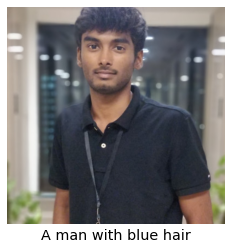

actions analysed: person standing

dominantColorForeground: Grey

dominantColorBackground: Black


In [7]:
##visual feature recognition

def Visual_analyser(subscription_key, endpoint):

    analyze_url = endpoint + "vision/v3.1/analyze"

    # Set image_url to the URL of an image that you want to analyze.


    headers = {'Ocp-Apim-Subscription-Key': subscription_key}
    params = {'visualFeatures': 'Categories,Description,Color'}
    data = {'url': image_url}
    response = requests.post(analyze_url, headers=headers,
                             params=params, json=data)
    response.raise_for_status()

    # The 'analysis' object contains various fields that describe the image. The most
    # relevant caption for the image is obtained from the 'description' property.
    analysis = response.json()
    return analysis


def Action_analyser(analysis):
    action = analysis['description']['tags']
    print('actions analysed:',*action)
    print()
    
    
def Dominant_color_analyser(analysis):

    dominantColorForeground = analysis['color']['dominantColorForeground']
    dominantColorBackground = analysis['color']['dominantColorBackground']

    print('dominantColorForeground:', dominantColorForeground)
    print()
    print('dominantColorBackground:', dominantColorBackground)

#print(json.dumps(response.json()))
#credentials for Azure computer vision api
subscription_key = '31013f49241f44f6baf39b9630c5b00c'
endpoint = 'https://australia.cognitiveservices.azure.com/'

#Visual analysis
analysis = Visual_analyser(subscription_key, endpoint)

image_caption = analysis["description"]["captions"][0]["text"].capitalize()

# Display the image and overlay it with the caption.

print('   *** visual feature analysis ***   ')
image = Image.open(BytesIO(requests.get(image_url).content))
plt.imshow(image)
plt.axis("off")
_ = plt.title(image_caption, size="x-large", y=-0.1)
plt.show()

#action analysis
Action_analyser(analysis)

#dominant colors
Dominant_color_analyser(analysis)
